In [0]:
# The essentials
import pandas as pd
import numpy as np

import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

# Access our Google Drive
from google.colab import drive

In [20]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
final_phase_labels_15_14.csv
final_phase_labels_15_15.csv
final_phase_labels_15_1.csv
final_phase_labels_15_2.csv
final_phase_labels_15_3.csv
final_phase_labels_15_6.csv
final_phase_labels_15_7.csv
final_phase_labels_3_1.csv
final_phase_labels_3_2.csv
final_phase_labels_3_3.csv
final_phase_labels_9_8.csv
hcsta_features_3_3.csv
last_cleaned_test.csv
last_cleaned_train.csv
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
model_per_recipe_simple.csv
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_15_15.c

In [21]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')
all_data = pd.concat([train_df, test_df], axis=0)

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8,
                                               'final_rinse': 0})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)

recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse_num'] = recipe_df['pre_rinse'] * 1
recipe_df['caustic_num'] = recipe_df['caustic'] * 2
recipe_df['intermediate_rinse_num'] = recipe_df['intermediate_rinse'] * 4
recipe_df['acid_num'] = recipe_df['acid'] * 8
recipe_df['recipe'] = recipe_df['pre_rinse_num'] + recipe_df['caustic_num'] + recipe_df['intermediate_rinse_num'] + recipe_df['acid_num']

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
# Take a subsample of train and test set
train_sample_procs = np.random.choice(np.unique(train_df['process_id']), size=250, replace=False)
test_sample_procs = np.random.choice(np.unique(test_df['process_id']), size=250, replace=False)

train_df[train_df['process_id'].isin(train_sample_procs)].to_csv('train_values_sample.csv')
test_df[test_df['process_id'].isin(test_sample_procs)].to_csv('test_values_sample.csv')

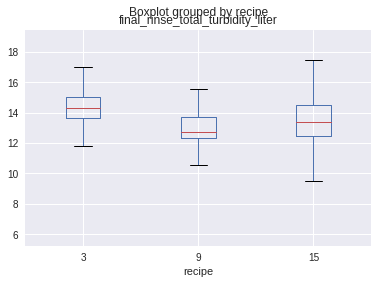

In [18]:
train_df = train_df.merge(recipe_df, left_on='process_id', right_index=True)
train_df = train_df.merge(label_df, left_on='process_id', right_index=True)
train_df['final_rinse_total_turbidity_liter'] = np.log(train_df['final_rinse_total_turbidity_liter'])
train_df.boxplot(by='recipe', column='final_rinse_total_turbidity_liter')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log1p
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(3380750.55, 3381222.45, -4.254626031250001, 86.89792790625)

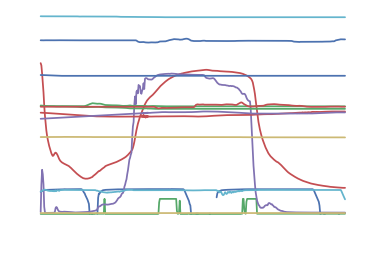

In [14]:
ts_real = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid'
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level',
    'tank_lsh_caustic',
    'tank_lsh_acid',
    'tank_lsh_clean_water',
    'tank_lsh_pre_rinse'
]

process_data = train_df[train_df['process_id'] == 24579]
process_data['return_flow'] = np.log1p(process_data['return_flow'])
process_data['supply_flow'] = np.log1p(process_data['supply_flow'])
ax = process_data[ts_real].plot(legend=False)
ax.set_facecolor('w')
ax.axis('off')

In [0]:
predictions = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_lgbm_9_8.csv', index_col=0)

In [0]:
normal_processes = set(train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 9].index)) & 
                                (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 8].index))]['process_id'])
weird_processes = set(train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)) & 
                               (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 15].index))]['process_id'])

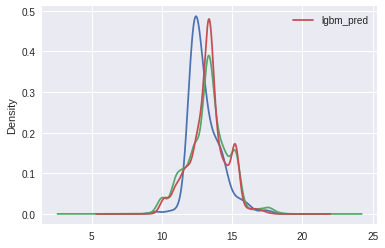

count    1.930000e+02
mean     1.220884e+06
std      3.952086e+06
min      1.380236e+04
25%      2.158018e+05
50%      3.309885e+05
75%      8.005651e+05
max      4.392247e+07
Name: final_rinse_total_turbidity_liter, dtype: float64
count    3.726000e+03
mean     2.117314e+06
std      7.034158e+06
min      2.939606e+03
25%      2.428570e+05
50%      6.194291e+05
75%      1.516852e+06
max      1.473866e+08
Name: final_rinse_total_turbidity_liter, dtype: float64
          lgbm_pred
count  3.947000e+03
mean   1.417019e+06
std    3.001815e+06
min    1.325582e+04
25%    2.920915e+05
50%    6.187869e+05
75%    1.226001e+06
max    5.546587e+07


In [0]:
f, ax = plt.subplots(1, 1)
np.log(label_df.loc[normal_processes]['final_rinse_total_turbidity_liter']).plot(kind='kde', ax=ax)
np.log(label_df.loc[weird_processes]['final_rinse_total_turbidity_liter']).plot(kind='kde', ax=ax)
predictions.plot(kind='kde', ax=ax)
plt.show()
print(label_df.loc[normal_processes]['final_rinse_total_turbidity_liter'].describe())
print(label_df.loc[weird_processes]['final_rinse_total_turbidity_liter'].describe())
print(np.exp(predictions).describe())

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))
  
print(custom_mape(np.exp(predictions.loc[normal_processes]['lgbm_pred']), label_df.loc[normal_processes]['final_rinse_total_turbidity_liter']),
custom_mape(np.exp(predictions.loc[normal_processes]['lgbm_pred'])/np.exp(0.5), label_df.loc[normal_processes]['final_rinse_total_turbidity_liter']))

0.5948079309104144 0.4200203274018571


In [0]:
predictions.head(5)

,lgbm_pred
27650,13.572648
24582,13.709473
24583,12.230469
23050,12.790259
24078,14.113366


In [0]:
train_df[train_df['process_id'] == 27650][['timestamp', 'phase']]

,timestamp,phase
row_id,,
5719315,2018-02-22 09:29:28,acid
5719316,2018-02-22 09:29:30,acid
5719317,2018-02-22 09:29:32,acid
5719318,2018-02-22 09:29:34,acid
5719319,2018-02-22 09:29:36,acid
5719320,2018-02-22 09:29:38,acid
5719321,2018-02-22 09:29:40,acid
5719322,2018-02-22 09:29:42,acid
5719323,2018-02-22 09:29:44,acid


In [0]:
prev_values = []
prev_prev_values = []
curr_values = []
for machine in tqdm.tqdm(set(train_df['object_id'])):
  machine_processes = train_df[train_df['object_id'] == machine].sort_values(by='timestamp')['process_id'].unique()
  for prev_prev_prev_process, prev_process, curr_process in zip(machine_processes[:-2], machine_processes[1:-1], machine_processes[2:]):
    prev_prev_values.append(label_df.loc[prev_prev_prev_process]['final_rinse_total_turbidity_liter'])
    prev_values.append(label_df.loc[prev_process]['final_rinse_total_turbidity_liter'])
    curr_values.append(label_df.loc[curr_process]['final_rinse_total_turbidity_liter'])
    
prev_values = np.array(prev_values)
prev_prev_values = np.array(prev_prev_values)
curr_values = np.array(curr_values)

100%|██████████| 94/94 [00:06<00:00, 13.87it/s]


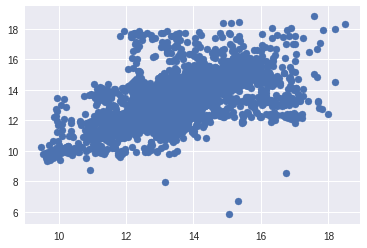

In [0]:
plt.scatter(x=np.log((prev_prev_values + prev_values) / 2), y=np.log(curr_values))

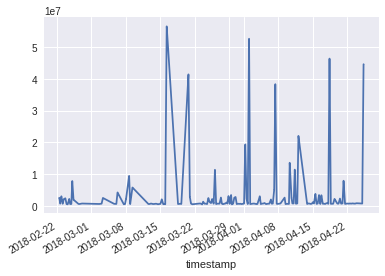

In [0]:
processes = train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)) &
                             (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 15].index)) &
                             (train_df['object_id'] == 933)].sort_values(by='timestamp')['process_id'].unique()

processes = label_df.loc[processes].merge(train_df.set_index('process_id')[['timestamp']], how='left', right_index=True, left_index=True).drop_duplicates()
processes = processes.set_index('timestamp', drop=True)
processes['final_rinse_total_turbidity_liter'].plot(kind='line')
#plt.plot(label_df.loc[processes]['final_rinse_total_turbidity_liter'].values)

In [0]:
train_df.groupby('object_id')['process_id'].nunique().sort_values(ascending=False)

object_id
405    350
932    185
933    182
934    179
204    165
112    125
930    122
113    107
921    100
216     98
923     98
922     98
306     98
924     94
217     91
308     88
116     88
942     86
941     86
940     86
944     85
943     84
309     80
114     76
300     65
301     64
925     63
955     63
303     62
956     60
      ... 
950     30
966     30
427     24
426     23
107     21
110     21
109     21
919     20
108     20
437     19
952     18
111     18
918     17
953     17
438     16
954     16
951     13
960     10
103      7
424      6
910      3
976      3
971      3
920      2
938      2
434      1
435      1
436      1
970      1
977      1
Name: process_id, Length: 94, dtype: int64

In [0]:
def get_processes(data, phases, train=True):
    filtered_processes = []
    phases = set(phases)
    processes = set(data['process_id'])
    for process in processes:
        process_phases = set(data[data['process_id'] == process]['phase'])
        if train:
            if phases.issubset(process_phases):
                filtered_processes.append(process)
        else:
            if len(phases) == len(process_phases) == len(phases.intersection(process_phases)):
                filtered_processes.append(process)
    return filtered_processes

combinations_per_recipe = {
    3: [1, 3, 2], 
    9: [8],
    15: [1, 2, 3, 6, 7, 14, 15]
}

process_comb_to_phases = {
    15: ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid'],
    3:  ['pre_rinse', 'caustic'],
    7:  ['pre_rinse', 'caustic', 'intermediate_rinse'],
    1:  ['pre_rinse'],
    8:  ['acid'],
    2:  ['caustic'],
    6:  ['caustic', 'intermediate_rinse'],
    14: ['caustic', 'intermediate_rinse', 'acid'],
}

import warnings; warnings.filterwarnings('ignore')
for recipe in [9]:
    recipe_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == recipe].index)]
    for process_combination in combinations_per_recipe[recipe]:
      print('Recipe = {} || Combination = {}'.format(recipe, process_combination))
      train_processes = get_processes(recipe_train_data, process_comb_to_phases[process_combination])
      if (recipe, process_combination) in [(9, 8)]:
        recipe_15_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)]
        extra_processes = get_processes(recipe_15_train_data, process_comb_to_phases[process_combination])
        train_processes += extra_processes
      
      final_phase_data = train_df[(train_df['process_id'].isin(train_processes)) & 
                                  (train_df['phase'] == 'final_rinse') &
                                  (train_df['target_time_period'] == True)]
      
      labels = final_phase_data.groupby('process_id')[['return_flow', 'return_turbidity']].agg(['mean', 'count', 'sum'])
      labels.columns = ['return_flow_mean', 'duration', 'return_flow_sum', 'return_turbidity_mean', 'drop', 'return_turbidity_sum']
      labels = labels.drop('drop', axis=1)
      labels.to_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination))
      
      print(labels.head(5))

Recipe = 9 || Combination = 8


KeyboardInterrupt: ignored

In [0]:
labels

return_flow                     return_turbidity        \
                    mean count           sum             mean count   
process_id                                                            
20002       20399.178709    57  1.162753e+06         0.256165    57   
20018       15149.749540    73  1.105932e+06         1.157804    73   
20043       15019.998440    72  1.081440e+06         1.403105    72   
20053       33745.699054    92  3.104604e+06         0.539743    92   
20076        4605.071206   238  1.096007e+06         0.811127   238   
20088       12960.209815    67  8.683341e+05         1.207828    67   
20100       22577.094118   200  4.515419e+06         2.437681   200   
20111       19732.439921    56  1.105017e+06         0.540145    56   
20113       16538.843522   185  3.059686e+06        10.499914   185   
20123       10561.122023    41  4.330060e+05         1.126355    41   
20131       27139.750342   112  3.039652e+06         2.286267   112   
20138       21252.825381    53  1.126400e+06         0.232642    53   
20147       34060.647945    91  3.099519e+06         0.602114    91   
20163       28176.425618    55  1.549703e+06         1.345618    55   
20165       33363.203315    89  2.969325e+06         0.533269    89   
20166       15676.179202   220  3.448759e+06         6.843845   220   
20171       13541.617164   365  4.942690e+06         0.209334   365   
20173       20092.338289    54  1.084986e+06         0.322373    54   
20175       22543.989335    53  1.194831e+06         0.670969    53   
20177       33853.419946    92  3.114515e+06         0.747676    92   
20187       29042.930842    38  1.103631e+06         1.709555    38   
20201       15849.059622   250  3.962265e+06         0.673134   250   
20205       33838.855033    90  3.045497e+06         0.492822    90   
20226       21253.965225    54  1.147714e+06         0.302815    54   
20236       22942.094545    99  2.271267e+06         0.557295    99   
20239       21973.192192    54  1.186552e+06         0.725389    54   
20247       28914.816395    38  1.098763e+06         1.540037    38   
20254       14870.306245   187  2.780747e+06         0.894708   187   
20256       33557.781822    90  3.020200e+06         0.576373    90   
20258       15725.588902   259  4.072928e+06         0.687350   259   
...                  ...   ...           ...              ...   ...   
27833       19083.521793   198  3.778537e+06         0.562976   198   
27837       26944.131576    37  9.969329e+05         4.632367    37   
27838       14293.067764    95  1.357841e+06         0.826937    95   
27844       21033.669332    54  1.135818e+06         0.184462    54   
27856       20064.446490    55  1.103545e+06         0.694181    55   
27863       12901.258434   283  3.651056e+06         0.937147   283   
27875       23005.022314    35  8.051758e+05         0.906085    35   
27876        5272.030888    72  3.795862e+05         0.330795    72   
27880       13104.525636    79  1.035258e+06         0.593080    79   
27882       16088.882270   181  2.912088e+06         0.653440   181   
27902       19670.807645    53  1.042553e+06         0.440033    53   
27903       15771.918303    75  1.182894e+06         1.228974    75   
27907        4707.839739    85  4.001664e+05         0.481728    85   
27908       12501.639697    75  9.376230e+05         0.975550    75   
27911        5103.378670   112  5.715784e+05         1.170228   112   
27914       33056.147489    88  2.908941e+06         0.733532    88   
27922       21223.422260    54  1.146065e+06         0.341328    54   
27928       16052.151256   243  3.900673e+06         0.664051   243   
27932       19649.547624    58  1.139674e+06         0.182716    58   
27933       21636.686412    54  1.168381e+06         0.731149    54   
27937       15740.283778   190  2.990654e+06         1.353158   190   
27938       10955.494114    80  8.764395e+05         1.404396    80   
27939       15281.481188   251  3.835

In [0]:
train_df.groupby('object_id')['process_id'].nunique().sort_values(ascending=False)

object_id
405    350
932    185
933    182
934    179
204    165
112    125
930    122
113    107
921    100
216     98
923     98
922     98
306     98
924     94
217     91
308     88
116     88
942     86
941     86
940     86
944     85
943     84
309     80
114     76
300     65
301     64
925     63
955     63
303     62
956     60
      ... 
950     30
966     30
427     24
426     23
107     21
110     21
109     21
919     20
108     20
437     19
952     18
111     18
918     17
953     17
438     16
954     16
951     13
960     10
103      7
424      6
910      3
976      3
971      3
920      2
938      2
434      1
435      1
436      1
970      1
977      1
Name: process_id, Length: 94, dtype: int64

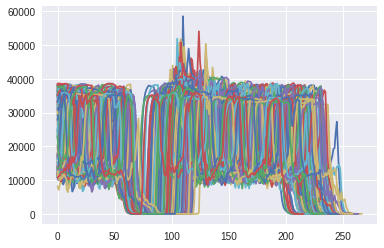

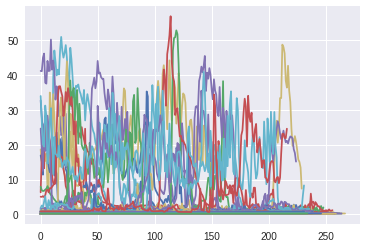

In [0]:
recipe_train_data = train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)) &
                             (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 15].index)) &
                             (train_df['object_id'].isin([932])) & (train_df['phase'] == 'final_rinse')]

# plt.figure()
# for process in set(recipe_train_data['process_id']):
#   plt.plot(np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['supply_flow'].values, 0, 44260))
# plt.show()

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['return_flow'].values, 0, 60000))
plt.show()

# plt.figure()
# for process in set(recipe_train_data['process_id']):
#   plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_caustic'].values)
# plt.show()

# plt.figure()
# for process in set(recipe_train_data['process_id']):
#   plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_acid'].values)
# plt.show()

# plt.figure()
# for process in set(recipe_train_data['process_id']):
#   plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['target_time_period'].values)
# plt.show()

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_turbidity'].values, label=str(process))
# plt.legend()
plt.show()

# plt.figure()
# for process in set(recipe_train_data['process_id']):
#   plt.plot(np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['supply_flow'].values, 0, 80000) - np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['return_flow'].values, 0, 80000))
# plt.show()

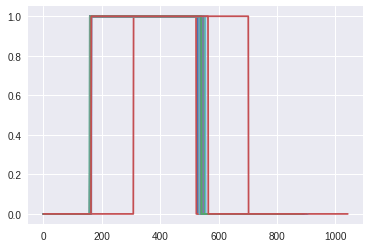

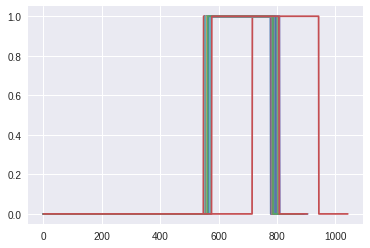

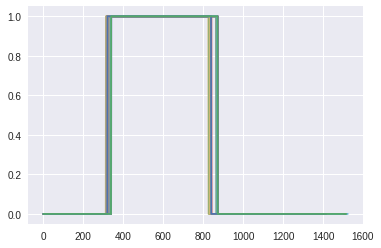

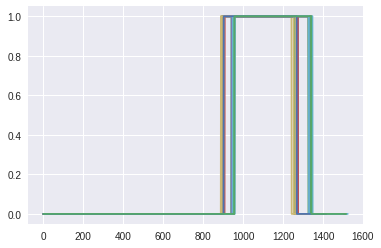

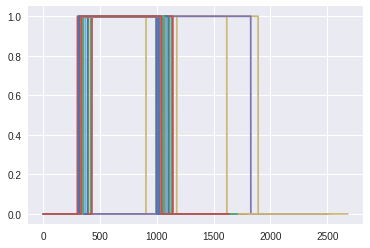

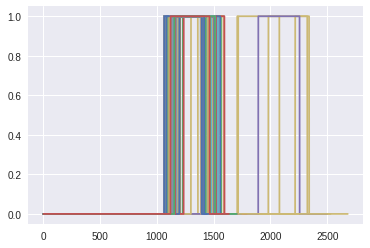

In [0]:
recipe_train_data = train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)) &
                             (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 15].index)) &
                             (train_df['object_id'] == 420)]

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_caustic'].values)
plt.show()

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_acid'].values)
plt.show()

recipe_train_data = train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)) &
                             (train_df['process_id'].isin(process_combinations[process_combinations['phase_int'] == 15].index)) &
                             (train_df['object_id'] == 409)]

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_caustic'].values)
plt.show()

plt.figure()
for process in set(recipe_train_data['process_id']):
  plt.plot(recipe_train_data[recipe_train_data['process_id'] == process]['return_acid'].values)
plt.show()

3856329.305557368


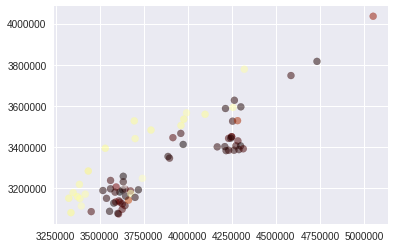

In [0]:
x = []
y = []
from matplotlib import cm
colors = []
small_procs = []
large_procs = []
for process in set(recipe_train_data['process_id']):
  supply_sum = np.sum(np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['supply_flow'].values, 0, 6000))
  return_sum = np.sum(np.clip(recipe_train_data[recipe_train_data['process_id'] == process]['return_flow'].values, 0, 6000))
  x.append(supply_sum)
  y.append(return_sum)
  first_phase_supply = np.sum(recipe_train_data[(recipe_train_data['process_id'] == process) & (recipe_train_data['phase'] == 'pre_rinse')]['supply_flow'])
  colors.append(first_phase_supply)
print(np.mean(x))
fig = plt.figure()
ax = plt.gca()
ax.scatter(x=x, y=y, c=colors, cmap=cm.afmhot, alpha=0.5)
plt.show()

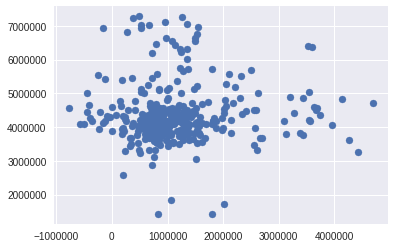

In [0]:
x = []
y = []
for process in set(recipe_train_data['process_id']):
  supply_sum = np.sum(np.clip(recipe_train_data[(recipe_train_data['process_id'] == process) & (recipe_train_data['phase'] != 'final_rinse')]['supply_flow'].values, 0, 80000))
  return_sum = np.sum(np.clip(recipe_train_data[(recipe_train_data['process_id'] == process) & (recipe_train_data['phase'] != 'final_rinse')]['return_flow'].values, 0, 80000))
  turbidity_avg = np.mean(recipe_train_data[(recipe_train_data['process_id'] == process) & (recipe_train_data['phase'] != 'final_rinse')]['return_turbidity'].values)
  x.append(turbidity_avg * (supply_sum - return_sum))
  y.append(label_df.loc[process]['final_rinse_total_turbidity_liter'])
fig = plt.figure()
ax = plt.gca()
ax.scatter(x=x, y=y)
plt.show()

In [0]:
from datetime import timedelta
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']
for process in set(train_df[(train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index))]['process_id']):
  print(process)
  process_data = train_df[(train_df['process_id'] == process)]
  for phase_ix, phase in enumerate(phases[:-1]):
    end = process_data[(process_data['phase'] == phase)]['timestamp'].max()
    start = process_data[(process_data['phase'] == phases[phase_ix + 1])]['timestamp'].min()
    
    if start - end > timedelta(seconds=2):
      print(process, start, end)
      input()

24581
24586
24588
24589
24593
24595
24599
24601
24602
24603
24605
24606
24608
24610
24611
24612
24613
24616
24617
24620
24621
24624
24627
24628
24630
24631
24632
24633
24636
24643
24645
24649
24654
24657
24659
24660
24661
24663
24664
24665
24666
24667
24669
24670
24673
24674
24675
24680
24682
24685
24686
24696
24698
24699
24700
24701
24702
24705
24707
24708
24709
24711
24714
24715
24716
24717
24718
24722
24726
24728
24729
24732
24735
24739
24741
24742
24743
24744
24746
24747
24749
24752
24753
24754
24755
24757
24758
24763
24764
24765
24766
24767
24768
24769
24771
24772
24774
24775
24776
24779
24781
24782
24783
24785
24790
24791
24794
24795
24797
24802
24803
24804
24807
24808
24810
24812
24813
24814
24815
24817
24818
24819
24820
24822
24823
24824
24825
24826
24827
24830
24832
24835
24836
24838
24839
24840
24841
24845
24846
24848
24849
24850
24851
24852
24854
24857
24860
24861
24862
24863
24864
24865
24866
24868
24870
24871
24875
24876
24879
24880
24881
24883
24884
24887
24888
24890
2489

In [0]:
timedelta(seconds=2)

datetime.timedelta(0, 2)

In [0]:
start - end > timedelta(seconds=2)

False

In [0]:
!pip install git+https://github.com/MentatInnovations/datastream.io#egg=dsio

In [0]:
from dsio.anomaly_detectors import Percentile1D

ModuleNotFoundError: ignored

In [0]:
ts = list(recipe_train_data[recipe_train_data['process_id'] == process]['supply_flow'].values)
detector = anomaly_detector.AnomalyDetector(ts)
anomalies = detector.get_anomalies()

InvalidDataFormat: ignored

In [0]:
ts

array([ 9161.603   , 10857.929   , 10818.143   , ...,    14.467592,
          14.467592,    14.467592])

In [0]:
train_df = train_df.merge(label_df, left_on='process_id', right_index=True)

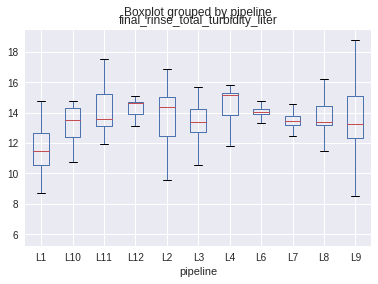

In [0]:
train_df.boxplot('final_rinse_total_turbidity_liter', by='pipeline')

In [0]:
train_df['final_rinse_total_turbidity_liter'] = np.log(train_df['final_rinse_total_turbidity_liter'])